<a href="https://colab.research.google.com/github/ToM4tto/MovieCompanion/blob/main/movie_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CSD3185 Group 26 Machine Learning Project**: 
## MovieCompanion - A Movie Recommendation System

## Mounting Google Drive

In [4]:
#Load the Drive helper and mount
from google.colab import drive

#This will prompt for authorisation
drive.mount('/content/drive')

Mounted at /content/drive


## Loading Data

In [5]:
import pandas as pd 
import numpy as np 
df1 = pd.read_csv("/content/drive/MyDrive/tmdb_5000_movies.csv")
df2 = pd.read_csv("/content/drive/MyDrive/tmdb_5000_credits.csv")
df2.columns = ['id','title','cast','crew'] #df2 movie_id has to be renamed to id to merge w/ df1

# Merge the two DataFrames on the 'id' column
df1 = df1.merge(df2,on='id')

# Drop the duplicate column 'title_y'
df1 = df1.drop('title_y', axis=1)

# Rename the column 'title_x' to 'title'
df1 = df1.rename(columns={'title_x': 'title'})

#Peek our data
df1.head(3)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."


## Visualising Data

In [6]:
import matplotlib.pyplot as plt

#enable graph render inline on Jupyter notebooks
%matplotlib inline 

#Make smaller dataframe with lesser cols
ratings = df1[["title", "vote_average", "vote_count"]]

# Sort the DataFrame by highest vote_score given the highest vote_count
ratings = ratings.sort_values(['vote_count', 'vote_average'], ascending=[False, False])

#Peek at our data
ratings.head(5)

,title,vote_average,vote_count
96,Inception,8.1,13752
65,The Dark Knight,8.2,12002
0,Avatar,7.2,11800
16,The Avengers,7.4,11776
788,Deadpool,7.4,10995


Distribution of Vote_Count (frequency vs vote_count)


<AxesSubplot:>

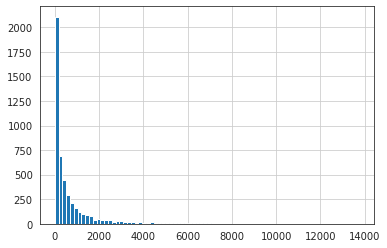

In [78]:
#Print Distribution of vote_count
print("Distribution of Vote_Count (frequency vs vote_count)")
ratings['vote_count'].hist(bins=80)

Distribution of Average Vote (frequency vs vote_average)


<AxesSubplot:>

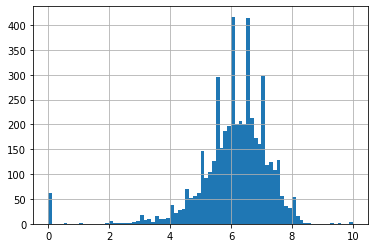

In [8]:
#Print Distribution of Average Votes
print("Distribution of Average Vote (frequency vs vote_average)")
ratings['vote_average'].hist(bins=80)

## Content-based Filtering

### Plot overview based Recommender

We will be computing scores for all movies based on **plot overview**  in order to make recommendations.

To do so, we need to compute the **Term Frequency-Inverse Document Frequency (TF-IDF) vectors**  for each plot overview. The TF-IDF score for a given word in a given document is high if that word appears frequently in that document but infrequently in the other documents. Conversely, the score is low if the word appears frequently in many documents in the corpus. By calculating the TF-IDF score for each word in each document, we can identify the words that are most strongly associated with each document, which can be useful for tasks such as document classification or information retrieval.

We will obtain a **TF-IDF matrix**  where each column represents a word in the combined set of movie overviews and each row represents a movie. Each element would represent the TFIDF score of the word in col for the movie in row. This allows us to filter significant words and therefore their significance to the various movies, helping us in our recommendation.

In [20]:
#Compute Term Frequency-Inverse Document Frequency (TF-IDF) vectors for each plot overview
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove common english stop words e.g: "the", "a"
tfidf = TfidfVectorizer(stop_words = "english")

#Clean Data by removing NaN empty string
df1["overview"] = df1["overview"].fillna("")

#Construct TF-IDF matrix by fitting and transforming the data (text) into a TF-IDF matrix representation
tfidf_matrix = tfidf.fit_transform(df1["overview"])

#Output the shape of tfidf_matrix
# 20978 different words describe 4803 movies in our data
tfidf_matrix.shape

(4803, 20978)

Calculate the Cosine Similarity: 

In [25]:
#Import linear_kernel (dot product)
from sklearn.metrics.pairwise import linear_kernel

#Cosine similarity is the dot product between two normalized vectors, the similarity between all pairs of movies in the dataset
#each element (i,j) in the cosine_sim matrix represents the dot product of the ith row of tfidf with the jth row of tfidf,
#this calculates similarity with every other movie (row)
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

#Create a mapping between movie titles and their indices in the dataset, dropping duplicate movie titles
title_to_indices = pd.Series(df1.index, df1['title']).drop_duplicates()

In [49]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim):
    # Error checking, invalid movie title
    if (title not in title_to_indices.index):
      print("Movie not in dataset, cannot recommend")
      return
    # Index of the movie that has the title
    index = title_to_indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = cosine_sim[index]

    # Sort movies based on the similarity scores in desc order and return top 10 most similar
    # Gets the array of indices if it were to be sorted
    movie_indices = np.argsort(-sim_scores)[1:11]

    # Return the top 10 most similar movies, gets location from df1
    return df1.loc[movie_indices, 'title']


In [50]:
get_recommendations('Iron Man', cosine_sim)

79                     Iron Man 2
31                     Iron Man 3
1868           Cradle 2 the Grave
7         Avengers: Age of Ultron
538                       Hostage
119                 Batman Begins
1290     Baahubali: The Beginning
4574                     Roadside
2044           The Little Vampire
2633    The Clan of the Cave Bear
Name: title, dtype: object